In [1]:
print('hola!')

hola!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from math import sqrt
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras.utils.np_utils import to_categorical
from keras.datasets import mnist
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras import callbacks
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
tfd = tfp.distributions

C:\Users\loren\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
os.chdir('C:\\Users\\loren\\OneDrive\\Desktop\\Lezioni uni\\Bayesian Analysis\\Progetto')

In [4]:
scaler = StandardScaler()
detector = IsolationForest(n_estimators=1000, contamination="auto", random_state=0)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [5]:
df_weather = pd.read_csv("weather_features.csv", parse_dates=['dt_iso'])
df_energy = pd.read_csv("energy_dataset.csv", parse_dates=['time'])

In [6]:
df_energy['generation coal all'] = df_energy['generation fossil hard coal'] + df_energy[
    'generation fossil brown coal/lignite']
df_energy['generation hydro all'] = df_energy['generation hydro water reservoir'] + df_energy[
    'generation hydro pumped storage consumption'] + df_energy['generation hydro run-of-river and poundage']

In [7]:
# Drop unusable columns

df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale',
                            'generation fossil peat', 'generation geothermal',
                            'generation hydro pumped storage aggregated', 'generation marine',
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'generation hydro water reservoir','generation hydro pumped storage consumption',
                            'generation hydro run-of-river and poundage', 'generation fossil hard coal',
                            'generation fossil brown coal/lignite'],
                            axis=1)

In [8]:
df_energy.head()

,time,generation biomass,generation fossil gas,generation fossil oil,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,generation coal all,generation hydro all
0,2015-01-01 00:00:00+01:00,447.0,4844.0,162.0,7096.0,43.0,73.0,49.0,196.0,6378.0,17.0,6436.0,26118.0,25385.0,50.10,65.41,5150.0,3813.0
1,2015-01-01 01:00:00+01:00,449.0,5196.0,158.0,7096.0,43.0,71.0,50.0,195.0,5890.0,16.0,5856.0,24934.0,24382.0,48.10,64.92,5083.0,3587.0
2,2015-01-01 02:00:00+01:00,448.0,4857.0,157.0,7099.0,43.0,73.0,50.0,196.0,5461.0,8.0,5454.0,23515.0,22734.0,47.33,64.48,4904.0,3508.0
3,2015-01-01 03:00:00+01:00,438.0,4314.0,160.0,7098.0,43.0,75.0,50.0,191.0,5238.0,2.0,5151.0,22642.0,21286.0,42.27,59.32,4385.0,3231.0
4,2015-01-01 04:00:00+01:00,428.0,4130.0,156.0,7097.0,43.0,74.0,42.0,189.0,4935.0,9.0,4861.0,21785.0,20264.0,38.41,56.04,4027.0,3499.0


In [9]:
df_energy['generation non-renewable'] = df_energy['generation fossil gas'] + df_energy['generation fossil oil'] + df_energy['generation nuclear'] + df_energy['generation other'] + \
                                        df_energy['generation coal all'] + df_energy['generation waste']
df_energy['generation renewable'] = df_energy['generation solar'] + df_energy['generation biomass'] + df_energy['generation hydro all'] + df_energy['generation other renewable'] + \
                                    df_energy['generation wind onshore']

In [10]:
df_energy.head()

,time,generation biomass,generation fossil gas,generation fossil oil,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,generation coal all,generation hydro all,generation non-renewable,generation renewable
0,2015-01-01 00:00:00+01:00,447.0,4844.0,162.0,7096.0,43.0,73.0,49.0,196.0,6378.0,17.0,6436.0,26118.0,25385.0,50.10,65.41,5150.0,3813.0,17491.0,10760.0
1,2015-01-01 01:00:00+01:00,449.0,5196.0,158.0,7096.0,43.0,71.0,50.0,195.0,5890.0,16.0,5856.0,24934.0,24382.0,48.10,64.92,5083.0,3587.0,17771.0,10047.0
2,2015-01-01 02:00:00+01:00,448.0,4857.0,157.0,7099.0,43.0,73.0,50.0,196.0,5461.0,8.0,5454.0,23515.0,22734.0,47.33,64.48,4904.0,3508.0,17256.0,9540.0
3,2015-01-01 03:00:00+01:00,438.0,4314.0,160.0,7098.0,43.0,75.0,50.0,191.0,5238.0,2.0,5151.0,22642.0,21286.0,42.27,59.32,4385.0,3231.0,16191.0,9032.0
4,2015-01-01 04:00:00+01:00,428.0,4130.0,156.0,7097.0,43.0,74.0,42.0,189.0,4935.0,9.0,4861.0,21785.0,20264.0,38.41,56.04,4027.0,3499.0,15642.0,8978.0


In [11]:
df_energy.describe().round(2)

,generation biomass,generation fossil gas,generation fossil oil,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,generation coal all,generation hydro all,generation non-renewable,generation renewable
count,35045.00,35046.00,35045.00,35047.00,35046.00,35046.00,35046.00,35045.00,35046.00,35064.00,35064.00,35064.00,35028.00,35064.00,35064.00,35046.00,35044.0,35044.00,35043.00
mean,383.51,5622.74,298.32,6263.91,60.23,85.64,1432.67,269.45,5464.48,1439.07,5471.22,28712.13,28696.94,49.87,57.88,4704.12,4052.9,17218.86,11419.55
std,85.35,2201.83,52.52,839.67,20.24,14.08,1680.12,50.20,3213.69,1677.70,3176.31,4594.10,4574.99,14.62,14.20,2245.64,2114.0,3982.96,4254.98
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,237.00,18105.00,18041.00,2.06,9.33,0.00,0.0,6363.00,0.00
25%,333.00,4126.00,263.00,5760.00,53.00,73.00,71.00,240.00,2933.00,69.00,2979.00,24793.75,24807.75,41.49,49.35,2678.00,2393.0,14031.75,8266.00
50%,367.00,4969.00,300.00,6566.00,57.00,88.00,616.00,279.00,4849.00,576.00,4855.00,28906.00,28901.00,50.52,58.02,4983.00,3589.0,17005.00,10896.00
75%,433.00,6429.00,330.00,7025.00,80.00,97.00,2578.00,310.00,7398.00,2636.00,7353.00,32263.25,32192.00,60.53,68.01,6503.00,5314.0,19973.00,14023.00
max,592.00,20034.00,449.00,7117.00,106.00,119.00,5792.00,357.00,17436.00,5836.00,17430.00,41390.00,41015.00,101.99,116.80,9320.00,11613.0,34498.00,27691.00


In [12]:
df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)
df_energy = df_energy.set_index('time')

In [13]:
# Find NaNs and duplicates in df_energy

print('There are {} missing values or NaNs in df_energy.'
      .format(df_energy.isnull().values.sum()))

temp_energy = df_energy.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy based on all columns.'
      .format(temp_energy))

There are 279 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy based on all columns.


In [14]:
# Find the number of NaNs in each column

df_energy.isnull().sum(axis=0)

generation biomass                 19
generation fossil gas              18
generation fossil oil              19
generation nuclear                 17
generation other                   18
generation other renewable         18
generation solar                   18
generation waste                   19
generation wind onshore            18
forecast solar day ahead            0
forecast wind onshore day ahead     0
total load forecast                 0
total load actual                  36
price day ahead                     0
price actual                        0
generation coal all                18
generation hydro all               20
generation non-renewable           20
generation renewable               21
dtype: int64

In [15]:
# Define a function to plot different types of time-series

def plot_series(df=None, column=None, series=pd.Series([]),
                label=None, ylabel=None, title=None, start=0, end=None):
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

C:\Users\loren\AppData\Local\Temp\ipykernel_7624\169134172.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def plot_series(df=None, column=None, series=pd.Series([]),


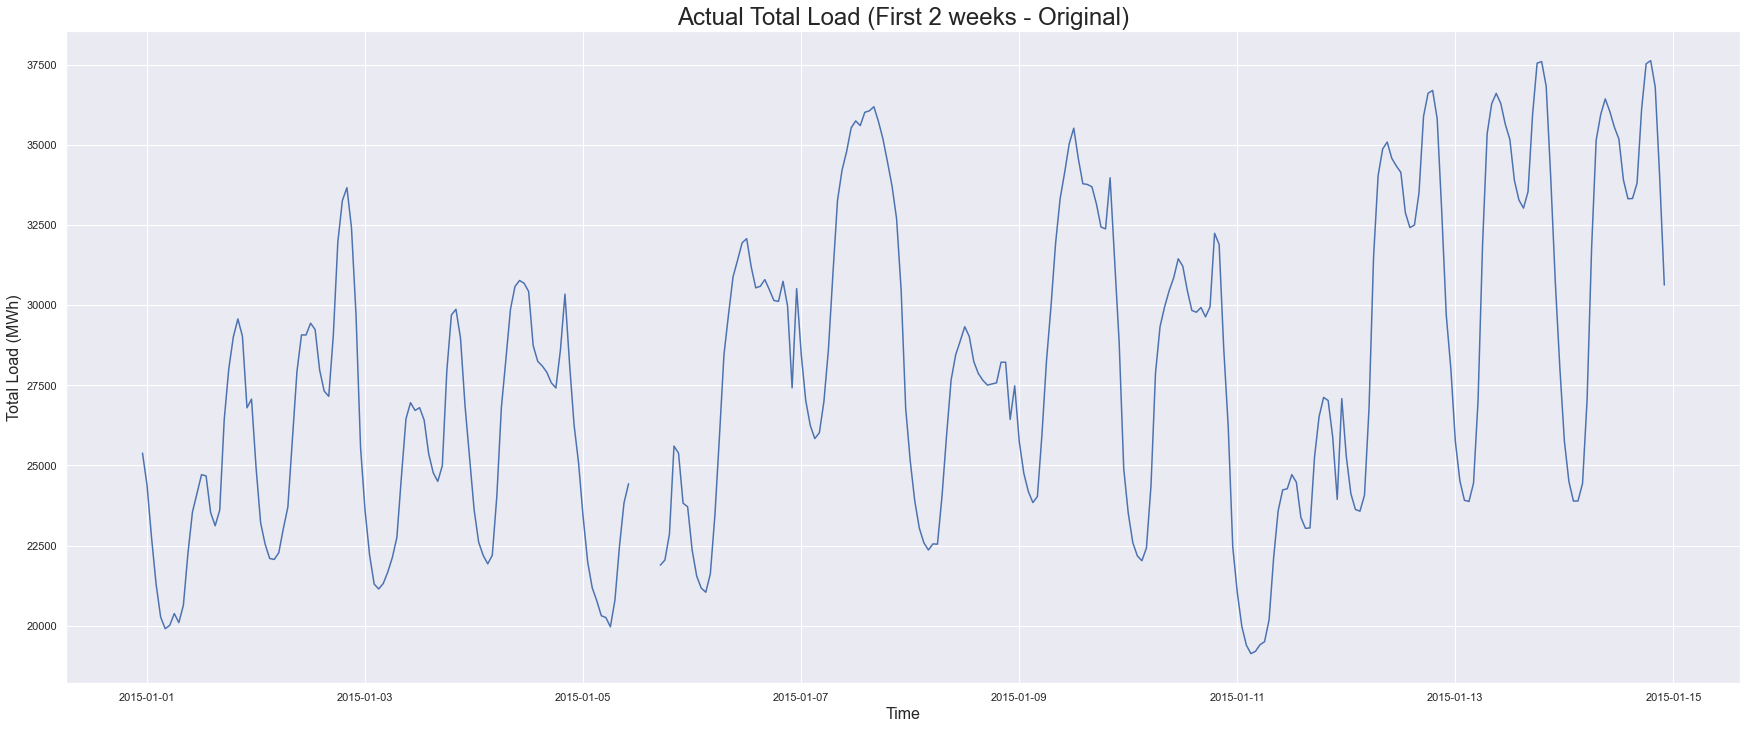

In [16]:
# Zoom into the plot of the hourly (actual) total load

ax = plot_series(df=df_energy, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Original)', end=24*7*2)
plt.show()

In [17]:
# Display the rows with null values

df_energy[df_energy.isnull().any(axis=1)].tail()

,generation biomass,generation fossil gas,generation fossil oil,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,generation coal all,generation hydro all,generation non-renewable,generation renewable
time,,,,,,,,,,,,,,,,,,,
2016-11-23 03:00:00+00:00,NaN,4838.0,269.0,5040.0,60.0,85.0,15.0,227.0,4598.0,3.0,4566.0,23469.0,23112.0,43.19,49.11,5447.0,2643.0,15881.0,NaN
2017-11-14 11:00:00+00:00,0.0,10064.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4325.0,7561.0,33805.0,NaN,60.53,66.17,0.0,0.0,10064.0,0.0
2017-11-14 18:00:00+00:00,0.0,12336.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128.0,5679.0,35592.0,NaN,68.05,75.45,0.0,0.0,12336.0,0.0
2018-06-11 16:00:00+00:00,331.0,7538.0,300.0,5856.0,52.0,96.0,170.0,269.0,9165.0,125.0,10329.0,34752.0,NaN,69.87,64.93,5866.0,5393.0,19881.0,15155.0
2018-07-11 07:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,849.0,9956.0,33938.0,NaN,63.01,69.79,NaN,NaN,NaN,NaN


In [18]:
# Fill null values using interpolation

df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [19]:
# Display the number of non-zero values in each column

print('Non-zero values in each column:\n', df_energy.astype(bool).sum(axis=0), sep='\n')

Non-zero values in each column:

generation biomass                 35060
generation fossil gas              35063
generation fossil oil              35061
generation nuclear                 35061
generation other                   35060
generation other renewable         35061
generation solar                   35061
generation waste                   35061
generation wind onshore            35061
forecast solar day ahead           34525
forecast wind onshore day ahead    35064
total load forecast                35064
total load actual                  35064
price day ahead                    35064
price actual                       35064
generation coal all                35061
generation hydro all               35061
generation non-renewable           35064
generation renewable               35061
dtype: int64


In [20]:
df_weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear


In [21]:
df_weather.describe().round(2)

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00
mean,289.62,288.33,291.09,1069.26,68.42,2.47,166.59,0.08,0.00,0.00,25.07,759.83
std,8.03,7.96,8.61,5969.63,21.90,2.10,116.61,0.40,0.01,0.22,30.77,108.73
min,262.24,262.24,262.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,200.00
25%,283.67,282.48,284.65,1013.00,53.00,1.00,55.00,0.00,0.00,0.00,0.00,800.00
50%,289.15,288.15,290.15,1018.00,72.00,2.00,177.00,0.00,0.00,0.00,20.00,800.00
75%,295.15,293.73,297.15,1022.00,87.00,4.00,270.00,0.00,0.00,0.00,40.00,801.00
max,315.60,315.15,321.15,1008371.00,100.00,133.00,360.00,12.00,2.32,21.50,100.00,804.00


In [22]:
# Print the type of each variable in df_weather

df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [23]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

In [24]:
df_weather = df_convert_dtypes(df_weather, np.int64, np.float64)

In [25]:
df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['dt_iso'], axis=1)
df_weather = df_weather.set_index('time')

In [26]:
# Display average weather features grouped by each city

mean_weather_by_city = df_weather.groupby('city_name').mean()
mean_weather_by_city

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
city_name,,,,,,,,,,,,
Barcelona,289.848248,288.594704,291.021987,1284.010486,73.994221,2.786588,187.188043,0.117079,0.000327,0.000000,23.229648,760.917465
Bilbao,286.378489,284.916661,288.036687,1017.567439,79.089455,1.957470,159.883536,0.123493,0.001034,0.023455,43.960697,723.943228
Madrid,288.061071,286.824877,289.155600,1011.838448,59.776932,2.441696,173.293159,0.055083,0.000129,0.000029,22.397028,762.260264
Seville,293.105431,291.184103,295.962431,1018.504711,64.140732,2.483787,151.757179,0.045392,0.000180,0.000000,14.748770,771.409849
Valencia,290.780780,290.222277,291.355025,1015.973794,65.145113,2.692815,160.753820,0.035924,0.000226,0.000154,20.820999,781.228283


In [27]:
# Find NaNs and duplicates in df_weather

print('There are {} missing values or NaNs in df_weather.'
      .format(df_weather.isnull().values.sum()))

temp_weather = df_weather.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_weather based on all columns.'
      .format(temp_weather))

There are 0 missing values or NaNs in df_weather.
There are 9935 duplicate rows in df_weather based on all columns.


In [28]:
# Display the number of rows in each dataframe

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

cities = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]),
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35145 observations in df_weather about city: Valencia.
There are 36267 observations in df_weather about city: Madrid.
There are 35951 observations in df_weather about city: Bilbao.
There are 35476 observations in df_weather about city:  Barcelona.
There are 35557 observations in df_weather about city: Seville.


In [29]:
# Create df_weather_2 and drop duplicate rows in df_weather

df_weather_2 = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                        keep='last').set_index('time')

df_weather = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                      keep='first').set_index('time')

In [30]:
# Display the number of rows in each dataframe again

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]),
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35064 observations in df_weather about city: Valencia.
There are 35064 observations in df_weather about city: Madrid.
There are 35064 observations in df_weather about city: Bilbao.
There are 35064 observations in df_weather about city:  Barcelona.
There are 35064 observations in df_weather about city: Seville.


In [31]:
# Display all the unique values in the column 'weather_description'

weather_description_unique = df_weather['weather_description'].unique()
weather_description_unique

array(['sky is clear', 'few clouds', 'scattered clouds', 'broken clouds',
       'overcast clouds', 'light rain', 'moderate rain',
       'heavy intensity rain', 'mist', 'heavy intensity shower rain',
       'shower rain', 'very heavy rain', 'thunderstorm with heavy rain',
       'thunderstorm with light rain', 'proximity thunderstorm',
       'thunderstorm', 'light intensity shower rain',
       'light intensity drizzle', 'thunderstorm with rain', 'fog',
       'smoke', 'drizzle', 'heavy intensity drizzle', 'haze',
       'proximity shower rain', 'light snow', 'rain and snow',
       'light rain and snow', 'snow', 'sleet', 'rain and drizzle',
       'light intensity drizzle rain', 'light shower snow',
       'proximity moderate rain', 'ragged shower rain', 'heavy snow',
       'sand dust whirls', 'proximity drizzle', 'dust',
       'light thunderstorm', 'squalls'], dtype=object)

In [32]:
# Display all the unique values in the column 'weather_main'

weather_main_unique = df_weather['weather_main'].unique()
weather_main_unique

array(['clear', 'clouds', 'rain', 'mist', 'thunderstorm', 'drizzle',
       'fog', 'smoke', 'haze', 'snow', 'dust', 'squall'], dtype=object)

In [33]:
# Display all the unique values in the column 'weather_id'

weather_id_unique = df_weather['weather_id'].unique()
weather_id_unique

array([800., 801., 802., 803., 804., 500., 501., 502., 701., 522., 521.,
       503., 202., 200., 211., 520., 300., 201., 741., 711., 301., 302.,
       721., 600., 616., 615., 601., 611., 311., 310., 620., 531., 602.,
       731., 761., 210., 771.])

In [34]:
# Define a function which will calculate R-squared score for the same column in two dataframes

def encode_and_display_r2_score(df_1, df_2, column, categorical=False):
    dfs = [df_1, df_2]
    if categorical:
        for df in dfs:
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
    r2 = r2_score(df_1[column], df_2[column])
    print("R-Squared score of {} is {}".format(column, r2.round(3)))

In [35]:
# Display the R-squared scores for the columns with qualitative weather descriptions in df_weather and df_weather_2

encode_and_display_r2_score(df_weather, df_weather_2, 'weather_description', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_main', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_id')

R-Squared score of weather_description is 0.973
R-Squared score of weather_main is 0.963
R-Squared score of weather_id is 0.921


In [36]:
# Drop columns with qualitative weather information
df_weather = df_weather.drop(['weather_main', 'weather_id',
                              'weather_description'],
                             axis=1)

In [37]:
df_weather.head()

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
time,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0
2015-01-01 00:00:00+00:00,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0
2015-01-01 01:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0
2015-01-01 02:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0
2015-01-01 03:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0


In [38]:
# Display the R-squared for all the columns in df_weather and df_weather_2

df_weather_cols = df_weather.columns.drop('city_name')

for col in df_weather_cols:
    encode_and_display_r2_score(df_weather, df_weather_2, col)

R-Squared score of temp is 1.0
R-Squared score of temp_min is 1.0
R-Squared score of temp_max is 1.0
R-Squared score of pressure is 1.0
R-Squared score of humidity is 1.0
R-Squared score of wind_speed is 1.0
R-Squared score of wind_deg is 1.0
R-Squared score of rain_1h is 1.0
R-Squared score of rain_3h is 1.0
R-Squared score of snow_3h is 1.0
R-Squared score of clouds_all is 1.0


In [39]:
# Display the number of duplicates in df_weather

temp_weather = df_weather.reset_index().duplicated(subset=['time', 'city_name'],
                                                   keep='first').sum()
print('There are {} duplicate rows in df_weather ' \
      'based on all columns except "time" and "city_name".'.format(temp_weather))

There are 0 duplicate rows in df_weather based on all columns except "time" and "city_name".


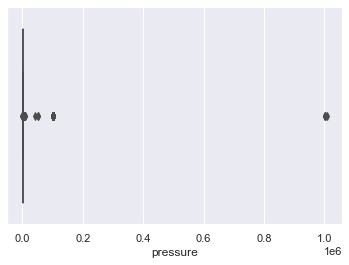

In [40]:
# Check for outliers in 'pressure' column

sns.boxplot(x=df_weather['pressure'])
plt.show()

In [41]:
# Replace outliers in 'pressure' with NaNs

df_weather.loc[df_weather.pressure > 1051, 'pressure'] = np.nan
df_weather.loc[df_weather.pressure < 931, 'pressure'] = np.nan

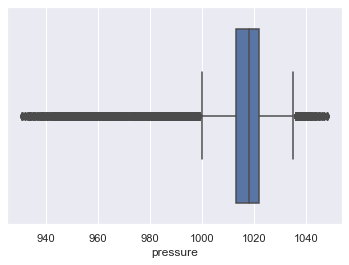

In [42]:
# Check for outliers in 'pressure' column again

sns.boxplot(x=df_weather['pressure'])
plt.show()

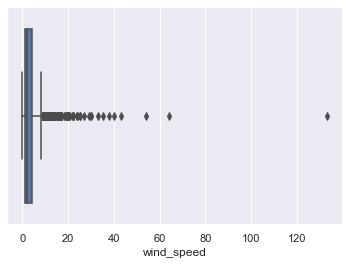

In [43]:
# Check for outliers in 'wind_speed' column

sns.boxplot(x=df_weather['wind_speed'])
plt.show()

In [44]:
# Replace outliers in 'wind_speed' with NaNs

df_weather.loc[df_weather.wind_speed > 50, 'wind_speed'] = np.nan

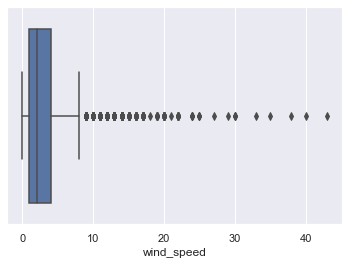

In [45]:
# Check for outliers in 'wind_speed' column again

sns.boxplot(x=df_weather['wind_speed'])
plt.show()

In [46]:
# Fill null values using interpolation

df_weather.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [47]:
# Split the df_weather into 5 dataframes (one for each city)

df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]

In [48]:
# Merge all dataframes into the final dataframe

df_final = df_energy

for df in dfs:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on=['time'], how='outer')
    df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)

df_final.columns

Index(['generation biomass', 'generation fossil gas', 'generation fossil oil',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'generation coal all', 'generation hydro all',
       'generation non-renewable', 'generation renewable', 'temp_Barcelona',
       'temp_min_Barcelona', 'temp_max_Barcelona', 'pressure_Barcelona',
       'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona',
       'rain_1h_Barcelona', 'rain_3h_Barcelona', 'snow_3h_Barcelona',
       'clouds_all_Barcelona', 'temp_Bilbao', 'temp_min_Bilbao',
       'temp_max_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao',
       'wind_speed_Bilbao', 'wind_deg_Bilbao', 'rain_1h_Bilbao',
       'rain_3h_Bilbao', 'snow_3h_Bilbao', 'clouds_all_Bilbao', 'temp

In [49]:
df_final.head()

,generation biomass,generation fossil gas,generation fossil oil,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,...,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,rain_3h_Valencia,snow_3h_Valencia,clouds_all_Valencia
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,4844.0,162.0,7096.0,43.0,73.0,49.0,196.0,6378.0,17.0,...,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0
2015-01-01 00:00:00+00:00,449.0,5196.0,158.0,7096.0,43.0,71.0,50.0,195.0,5890.0,16.0,...,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0
2015-01-01 01:00:00+00:00,448.0,4857.0,157.0,7099.0,43.0,73.0,50.0,196.0,5461.0,8.0,...,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0
2015-01-01 02:00:00+00:00,438.0,4314.0,160.0,7098.0,43.0,75.0,50.0,191.0,5238.0,2.0,...,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0
2015-01-01 03:00:00+00:00,428.0,4130.0,156.0,7097.0,43.0,74.0,42.0,189.0,4935.0,9.0,...,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0


In [50]:
# Display the number of NaNs and duplicates in the final dataframe

print('There are {} missing values or NaNs in df_final.'
      .format(df_final.isnull().values.sum()))

temp_final = df_final.duplicated(keep='first').sum()

print('\nThere are {} duplicate rows in df_energy based on all columns.'
      .format(temp_final))

There are 0 missing values or NaNs in df_final.

There are 0 duplicate rows in df_energy based on all columns.


In [51]:
cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for city in cities:
    df_final = df_final.drop(['rain_3h_{}'.format(city)], axis=1)

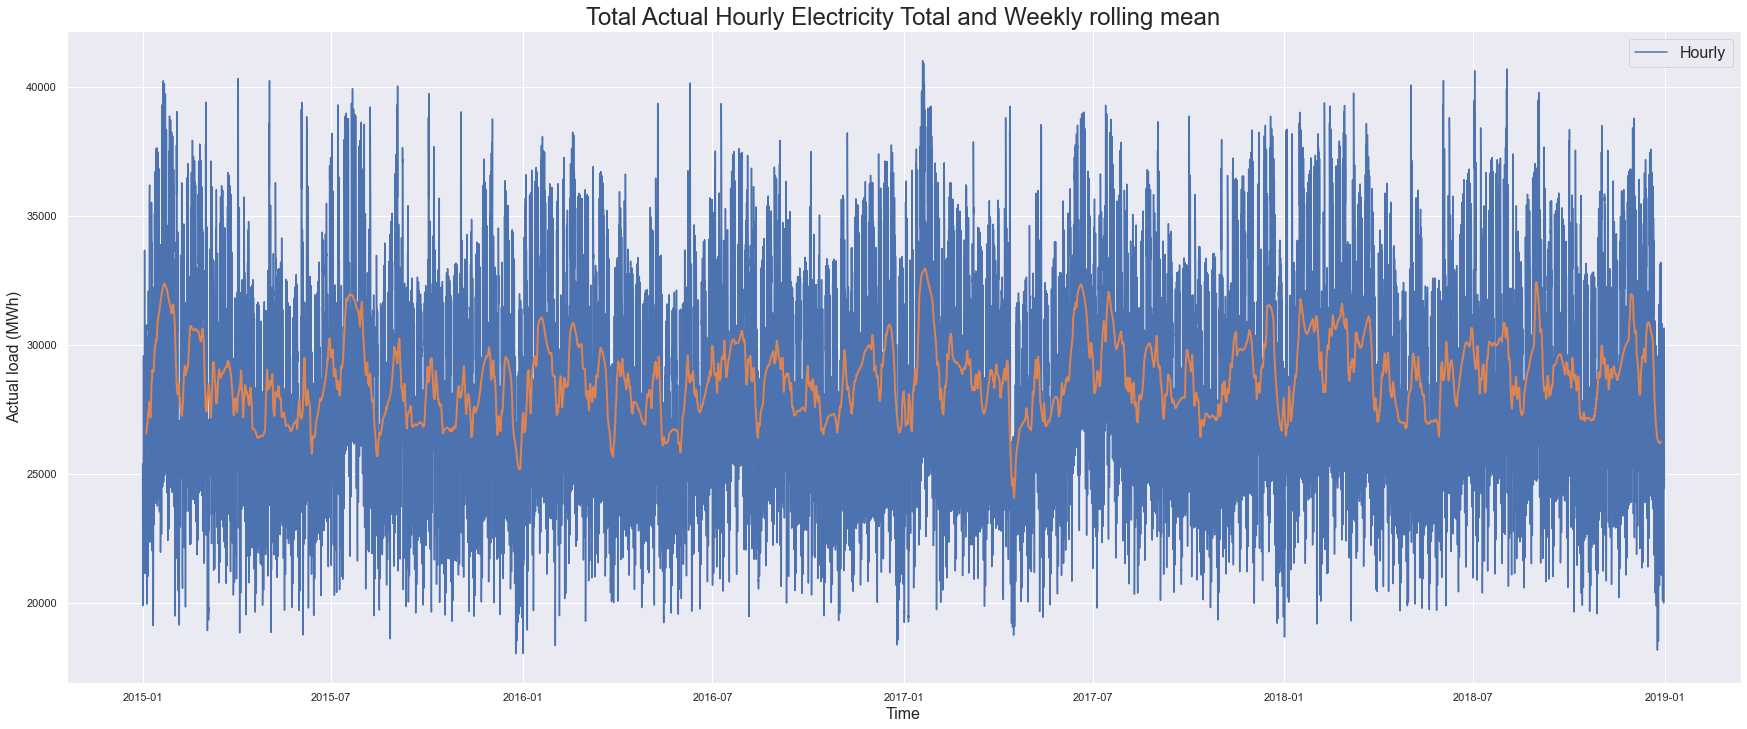

In [52]:
# Plot the hourly actual electricity total load, along with the weekly rolling mean

rolling = df_final['total load actual'].rolling(24*7, center=True).mean()
ax = plot_series(df_final, 'total load actual', label='Hourly', ylabel='Actual load (MWh)',
                 title='Total Actual Hourly Electricity Total and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

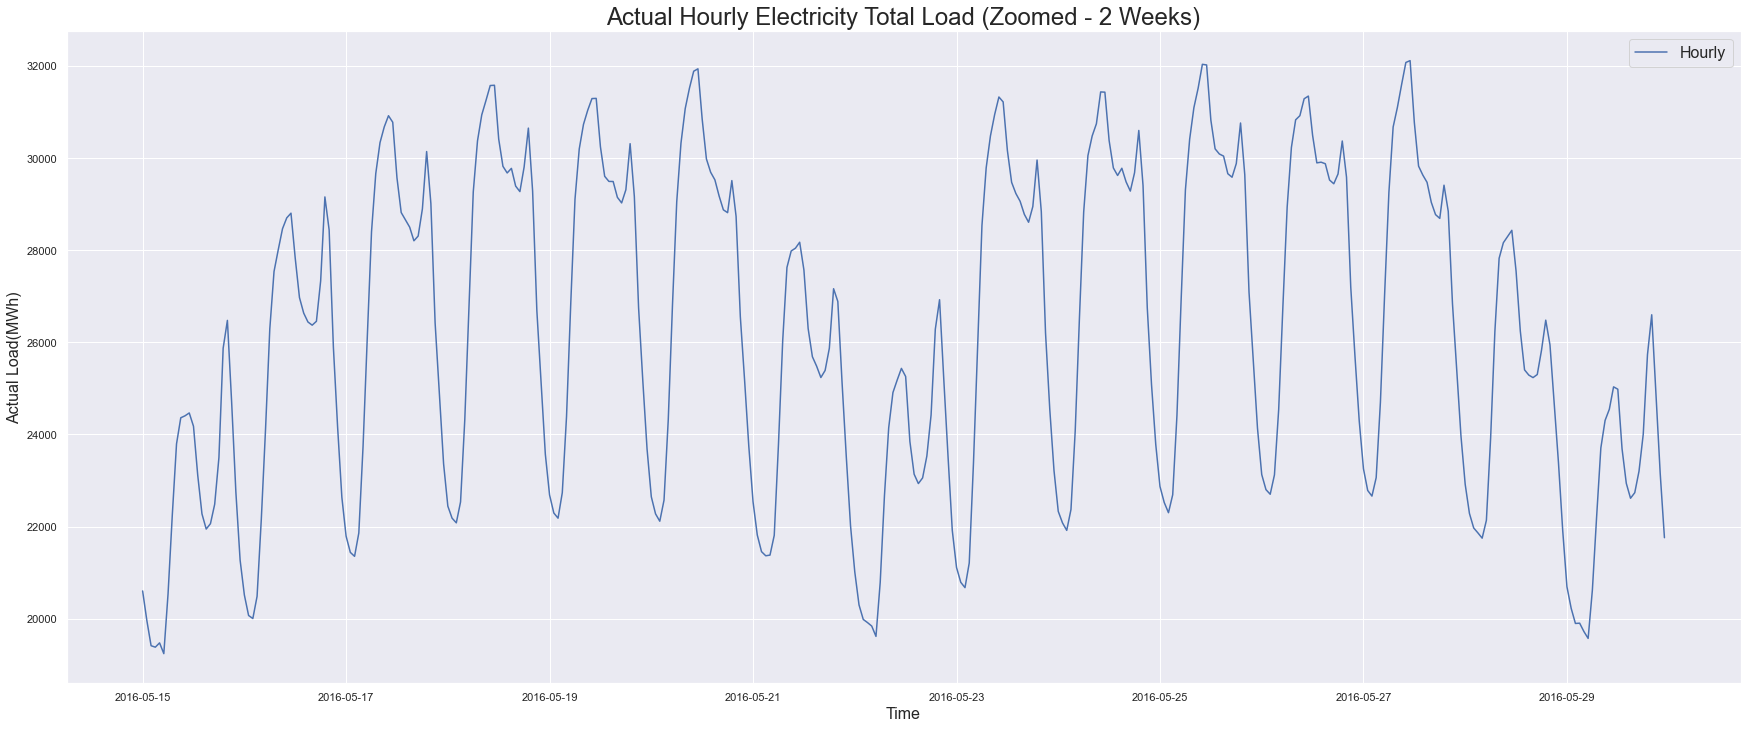

In [53]:
# Plot the actual electricity total load at a daily/weekly scale

ax = plot_series(df_final, 'total load actual', label='Hourly', ylabel='Actual Load(MWh)',
                 start=1 + 24 * 500, end=1 + 24 * 515,
                 title='Actual Hourly Electricity Total Load (Zoomed - 2 Weeks)')
plt.show()

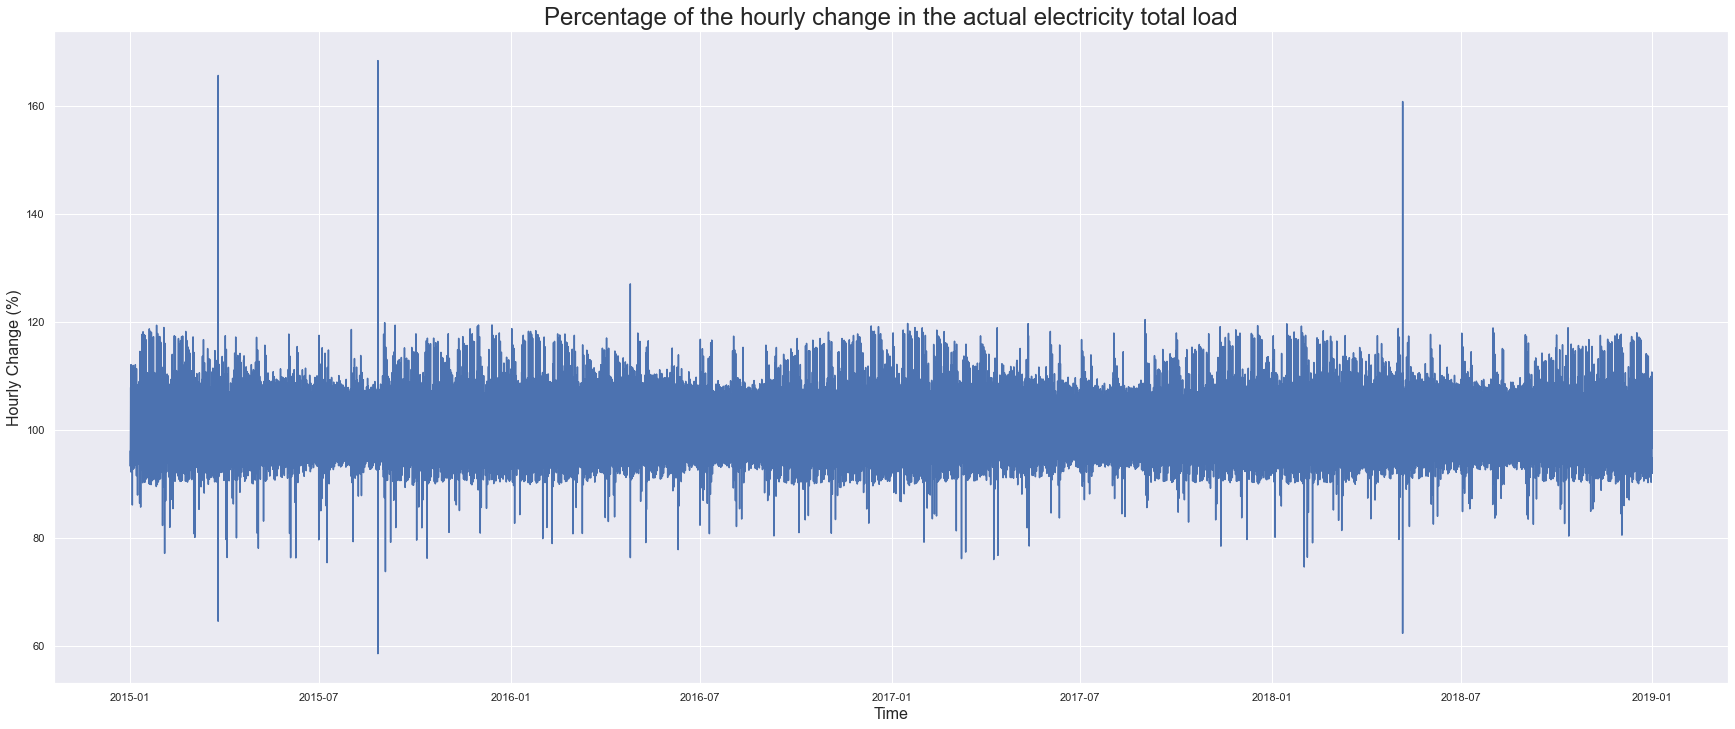

In [54]:
# Plot the percentage of the hourly change in the actual electricity load

change = df_energy['total load actual'].div(df_energy['total load actual'].shift(1)).mul(100)
ax = plot_series(series=change, ylabel='Hourly Change (%)',
                 title='Percentage of the hourly change in the actual electricity total load')
plt.show()

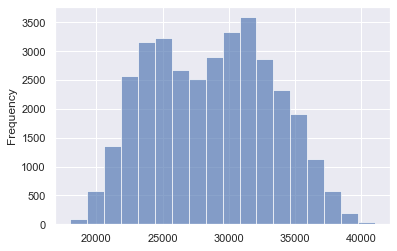

In [55]:
# Plot the histogram of the actual electricity price

ax = df_energy['total load actual'].plot.hist(bins=18, alpha=0.65)

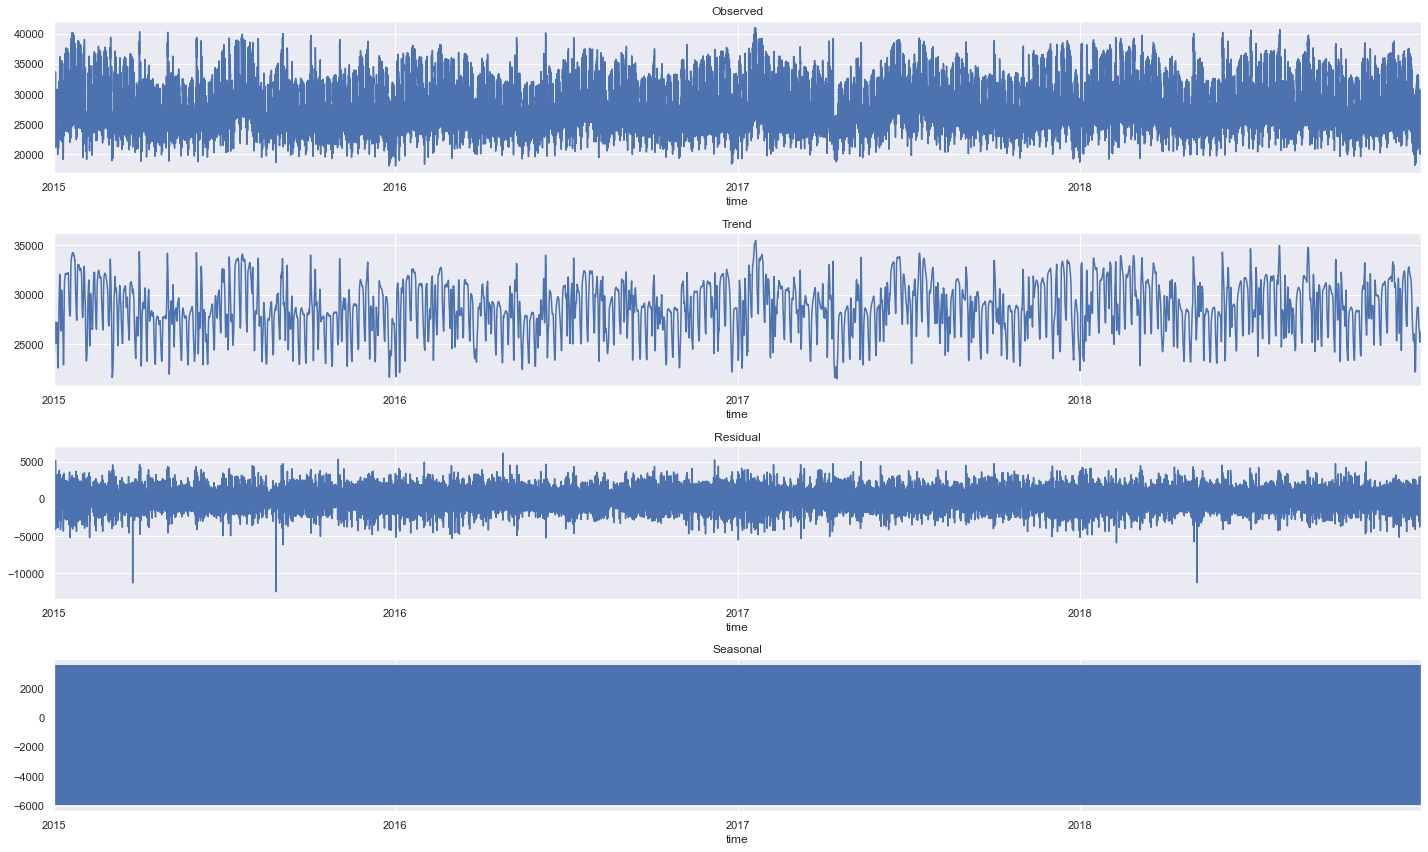

In [56]:
# Decompose the electricity load time series

res = sm.tsa.seasonal_decompose(df_energy['total load actual'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

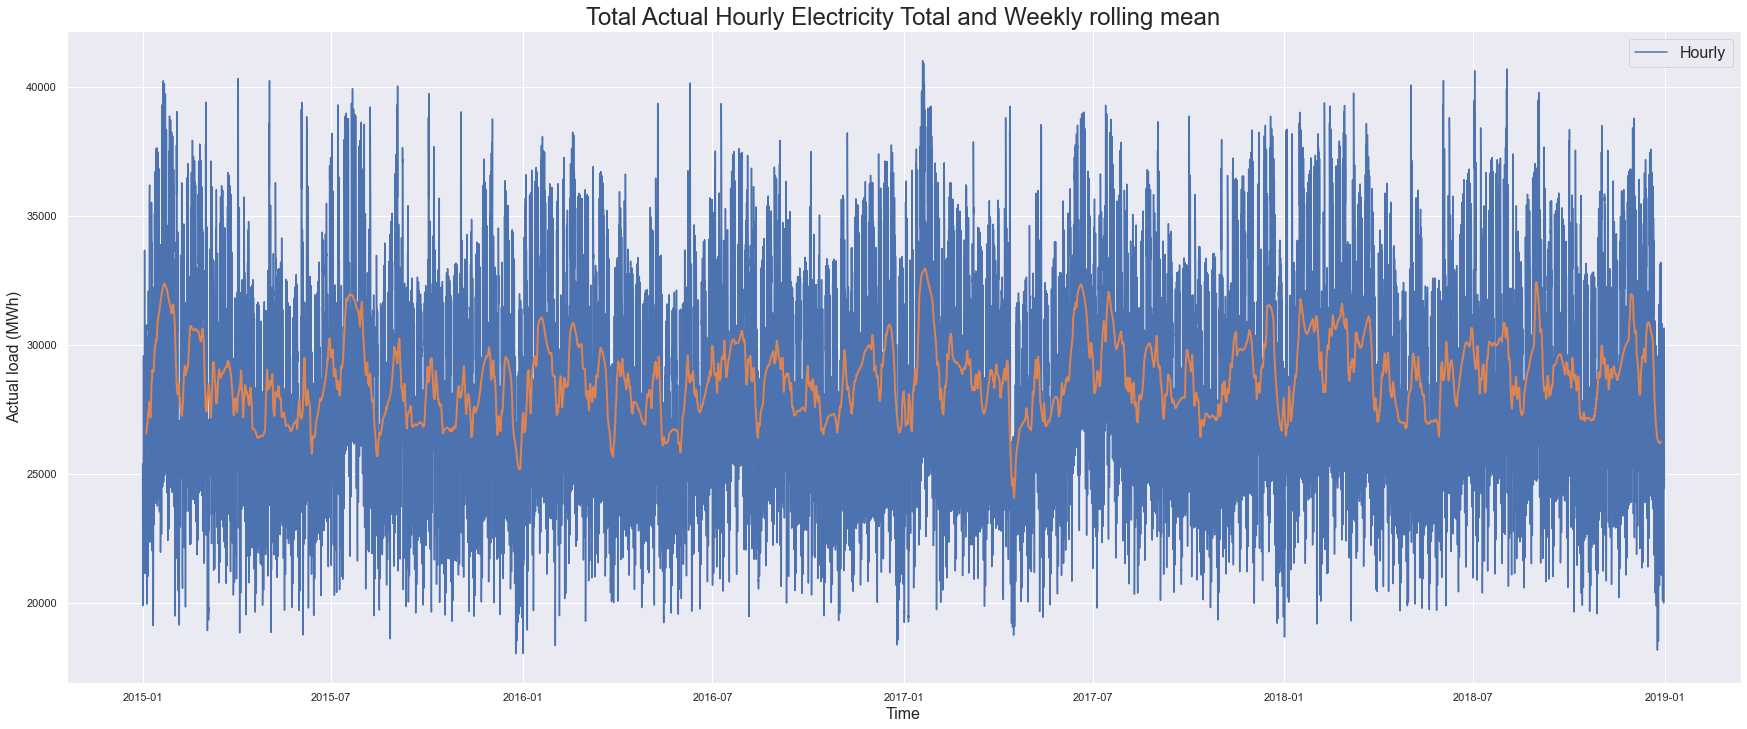

In [57]:
rolling = df_final['total load actual'].rolling(24*7, center=True).mean()
ax = plot_series(df_final, 'total load actual', label='Hourly', ylabel='Actual load (MWh)',
                 title='Total Actual Hourly Electricity Total and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')

plt.show()

In [58]:
# Generate 'hour', 'weekday' and 'month' features

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    df_final.loc[position, 'hour'] = hour
    df_final.loc[position, 'weekday'] = weekday
    df_final.loc[position, 'month'] = month

In [59]:
# Generate 'business hour' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    if 8 <= hour <= 18:
        df_final.loc[position, 'business hour'] = 1
    else:
        df_final.loc[position, 'business hour'] = 0

In [60]:
# Generate 'weekend' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    weekday = position.weekday()
    if (weekday == 6):
        df_final.loc[position, 'weekday'] = 2
    elif (weekday == 5):
        df_final.loc[position, 'weekday'] = 1
    else:
        df_final.loc[position, 'weekday'] = 0

In [61]:
# Generate cities list

cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

In [62]:
# Calculate the weight of every city

total_pop = 6155116 + 5179243 + 1645342 + 1305342 + 987000

weight_Madrid = 6155116 / total_pop
weight_Barcelona = 5179243 / total_pop
weight_Valencia = 1645342 / total_pop
weight_Seville = 1305342 / total_pop
weight_Bilbao = 987000 / total_pop

In [63]:
cities_weights = {'Madrid': weight_Madrid,
                  'Barcelona': weight_Barcelona,
                  'Valencia': weight_Valencia,
                  'Seville': weight_Seville,
                  'Bilbao': weight_Bilbao}

In [64]:
features_list = [c for c in df_final.columns if c.startswith('generation')]
features_list

['generation biomass',
 'generation fossil gas',
 'generation fossil oil',
 'generation nuclear',
 'generation other',
 'generation other renewable',
 'generation solar',
 'generation waste',
 'generation wind onshore',
 'generation coal all',
 'generation hydro all',
 'generation non-renewable',
 'generation renewable']

In [65]:
for city, weight in cities_weights.items():
    for feature in features_list:
        df_final[feature + ' ' + city] = df_final[feature]*weight

In [66]:
df_final.head()

,generation biomass,generation fossil gas,generation fossil oil,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,...,generation nuclear Bilbao,generation other Bilbao,generation other renewable Bilbao,generation solar Bilbao,generation waste Bilbao,generation wind onshore Bilbao,generation coal all Bilbao,generation hydro all Bilbao,generation non-renewable Bilbao,generation renewable Bilbao
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,4844.0,162.0,7096.0,43.0,73.0,49.0,196.0,6378.0,17.0,...,458.599547,2.779,4.717836,3.166767,12.667068,412.196718,332.833662,246.426166,1130.406521,695.396156
2015-01-01 00:00:00+00:00,449.0,5196.0,158.0,7096.0,43.0,71.0,50.0,195.0,5890.0,16.0,...,458.599547,2.779,4.588581,3.231395,12.602440,380.658305,328.503593,231.820261,1148.502332,649.316467
2015-01-01 01:00:00+00:00,448.0,4857.0,157.0,7099.0,43.0,73.0,50.0,196.0,5461.0,8.0,...,458.793431,2.779,4.717836,3.231395,12.667068,352.932938,316.935200,226.714658,1115.218966,616.550124
2015-01-01 02:00:00+00:00,438.0,4314.0,160.0,7098.0,43.0,75.0,50.0,191.0,5238.0,2.0,...,458.728803,2.779,4.847092,3.231395,12.343928,338.520917,283.393322,208.812731,1046.390257,583.719153
2015-01-01 03:00:00+00:00,428.0,4130.0,156.0,7097.0,43.0,74.0,42.0,189.0,4935.0,9.0,...,458.664175,2.779,4.782464,2.714372,12.214672,318.938665,260.256535,226.133007,1010.909542,580.229246


In [67]:
df_final['temp_min'] = (df_final['temp_min_Madrid'] + df_final['temp_min_Bilbao'] + df_final['temp_min_Barcelona'] + df_final['temp_min_Seville'] + df_final['temp_min_Valencia'])/5
df_final['temp'] = (df_final['temp_Madrid'] + df_final['temp_Bilbao'] + df_final['temp_Barcelona'] + df_final['temp_Seville'] + df_final['temp_Valencia'])/5
df_final['temp_max'] = (df_final['temp_max_Madrid'] + df_final['temp_max_Bilbao'] + df_final['temp_max_Barcelona'] + df_final['temp_max_Seville'] + df_final['temp_max_Valencia'])/5
df_final['pressure'] = (df_final['pressure_Madrid'] + df_final['pressure_Bilbao'] + df_final['pressure_Barcelona'] + df_final['pressure_Seville'] + df_final['pressure_Valencia'])/5
df_final['humidity'] = (df_final['humidity_Madrid'] + df_final['humidity_Bilbao'] + df_final['humidity_Barcelona'] + df_final['humidity_Seville'] + df_final['humidity_Valencia'])/5
df_final['wind_speed'] = (df_final['wind_speed_Madrid'] + df_final['wind_speed_Bilbao'] + df_final['wind_speed_Barcelona'] + df_final['wind_speed_Seville'] + df_final['wind_speed_Valencia'])/5
df_final['wind_deg'] = (df_final['wind_deg_Madrid'] + df_final['wind_deg_Bilbao'] + df_final['wind_deg_Barcelona'] + df_final['wind_deg_Seville'] + df_final['wind_deg_Valencia'])/5
df_final['rain_1h'] = (df_final['rain_1h_Madrid'] + df_final['rain_1h_Bilbao'] + df_final['rain_1h_Barcelona'] + df_final['rain_1h_Seville'] + df_final['rain_1h_Valencia'])/5
df_final['snow_3h'] = (df_final['snow_3h_Madrid'] + df_final['snow_3h_Bilbao'] + df_final['snow_3h_Barcelona'] + df_final['snow_3h_Seville'] + df_final['snow_3h_Valencia'])/5
df_final['clouds_all'] = (df_final['clouds_all_Madrid'] + df_final['clouds_all_Bilbao'] + df_final['clouds_all_Barcelona'] + df_final['clouds_all_Seville'] + df_final['clouds_all_Valencia'])/5

In [68]:
df_final.head().round(2)

,generation biomass,generation fossil gas,generation fossil oil,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,...,temp_min,temp,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,4844.0,162.0,7096.0,43.0,73.0,49.0,196.0,6378.0,17.0,...,272.49,272.49,272.49,1016.4,82.4,2.0,135.2,0.0,0.0,0.0
2015-01-01 00:00:00+00:00,449.0,5196.0,158.0,7096.0,43.0,71.0,50.0,195.0,5890.0,16.0,...,272.51,272.51,272.51,1016.2,82.4,2.0,135.8,0.0,0.0,0.0
2015-01-01 01:00:00+00:00,448.0,4857.0,157.0,7099.0,43.0,73.0,50.0,196.0,5461.0,8.0,...,272.10,272.10,272.10,1016.8,82.0,2.4,119.0,0.0,0.0,0.0
2015-01-01 02:00:00+00:00,438.0,4314.0,160.0,7098.0,43.0,75.0,50.0,191.0,5238.0,2.0,...,272.09,272.09,272.09,1016.6,82.0,2.4,119.2,0.0,0.0,0.0
2015-01-01 03:00:00+00:00,428.0,4130.0,156.0,7097.0,43.0,74.0,42.0,189.0,4935.0,9.0,...,272.15,272.15,272.15,1016.6,82.0,2.4,118.4,0.0,0.0,0.0


In [66]:
#Feature selection

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [73]:
X = df_final[['generation biomass', 'generation fossil gas', 'generation fossil oil', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind onshore', 'price actual', 'generation coal all','generation hydro all','temp_min', 'temp', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'snow_3h', 'clouds_all']]
y = df_final[['total load actual']]

In [74]:
model = sm.OLS(y, X).fit()
model.summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
generation biomass,0.524063,0.212318,2.468295,1.358058e-02,0.107913,0.940213
generation fossil gas,0.797098,0.006817,116.925809,0.000000e+00,0.783737,0.810460
generation fossil oil,16.340525,0.262749,62.190516,0.000000e+00,15.825528,16.855523
generation nuclear,0.809654,0.013015,62.208426,0.000000e+00,0.784144,0.835165
generation other,-1.823027,0.717371,-2.541259,1.104967e-02,-3.229097,-0.416956
generation other renewable,43.645558,1.228319,35.532753,1.040516e-271,41.238014,46.053103
generation solar,0.860448,0.008331,103.285277,0.000000e+00,0.844119,0.876777
generation waste,4.715921,0.306920,15.365312,4.169268e-53,4.114348,5.317494
generation wind onshore,0.548083,0.004327,126.658411,0.000000e+00,0.539602,0.556565
price actual,36.180628,0.957941,37.769168,5.121284e-306,34.303034,38.058222


In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [76]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit(X_test)

In [ ]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

In [7]:
data = data[columns].dropna(axis=0)

In [8]:
# Scale data to zero mean and unit variance.
X_t = scaler.fit_transform(data)
# Remove outliers.
is_inlier = detector.fit_predict(X_t)
X_t = X_t[(is_inlier > 0),:]
# Restore frame.
dataset = pd.DataFrame(X_t, columns=columns)
# Select labels for inputs and outputs.
inputs = ["PT08.S1(CO)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "AH"]
outputs = ["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]

In [9]:
# TRAINING
n_epochs = 50
n_samples = dataset.shape[0]
n_batches = 10
batch_size = np.floor(n_samples/n_batches)
buffer_size = n_samples

In [10]:
n_train = int(0.7*dataset.shape[0])

In [11]:
data = tf.data.Dataset.from_tensor_slices((dataset[inputs].values, dataset[outputs].values))
data = data.shuffle(n_samples, reshuffle_each_iteration=True)

In [12]:
data_train = data.take(n_train).batch(batch_size).repeat(n_epochs)
data_test = data.skip(n_train).batch(1)

In [13]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(len(outputs), dtype=tf.float64), scale=1.0), reinterpreted_batch_ndims=1)

In [14]:
model = tfk.Sequential([
tfk.layers.InputLayer(input_shape=(len(inputs),), name="input"),
tfk.layers.Dense(10, activation="relu", name="dense_1"),
tfk.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(
len(outputs)), activation=None, name="distribution_weights"),
tfp.layers.MultivariateNormalTriL(len(outputs), activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1/n_batches), name="output")
], name="model")

model.compile(optimizer="adam", loss=neg_log_likelihood)

model.fit(data_train, epochs=n_epochs, validation_data=data_test, verbose=False)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 10)                70        
                                                                 
 distribution_weights (Dense  (None, 14)               154       
 )                                                               
                                                                 
 output (MultivariateNormalT  ((None, 4),              0         
 riL)                         (None, 4))                         
                                                                 
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________


In [15]:
tfp.layers.DenseFlipout(10, activation="relu", name="dense_1")

In [16]:
samples = 500
iterations = 10
test_iterator = tf.compat.v1.data.make_one_shot_iterator(data_test)
X_true, Y_true, Y_pred = np.empty(shape=(samples, len(inputs))), np.empty(shape=(samples, len(outputs))), np.empty(
    shape=(samples, len(outputs), iterations))
for i in range(samples):
    features, labels = test_iterator.get_next()
    X_true[i, :] = features
    Y_true[i, :] = labels.numpy()
    for k in range(iterations):
        Y_pred[i, :, k] = model.predict(features)

# Calculate mean and standard deviation.
Y_pred_m = np.mean(Y_pred, axis=-1)
Y_pred_s = np.std(Y_pred, axis=-1)

In [20]:
import seaborn as sns

In [52]:
yyy = [i for l in Y_pred_m for i in l ]
len(yyy)

2000

In [53]:
xxx = [i for l in Y_true for i in l ]
len(xxx)

2000

In [26]:
Y_pred_s.flatten()

array([0.62558862, 0.01800166, 0.59567933, ..., 0.02753892, 0.59383681,
       0.63250731])

In [28]:
Y_true.flatten()

array([-1.88010963,  0.06873629, -1.72094769, ...,  0.18816339,
       -1.72094769, -1.90714772])

<AxesSubplot:>

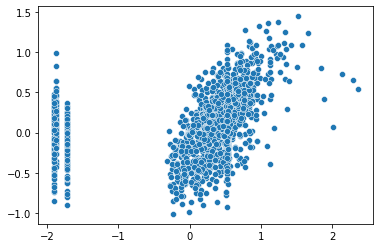

In [51]:
sns.scatterplot(x = xxx, y = yyy)

In [37]:
Y_pflat = Y_pred.ravel()

In [42]:
np.shape(Y_true.flatten())

(2000,)

In [54]:
np.shape(Y_pred)

(500, 4, 10)